In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

In [2]:
raw_df = pd.read_csv('data/zillow_data.csv')
raw_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


Filter only for Texas
<br>Drop Metro because there were many nulls, and it was redundant with other location data 
<br> Drop regionID and SizeRank because values were specific to Zillow 

In [3]:
raw_df = raw_df[raw_df['State']=='TX']
raw_df.drop(raw_df.columns[np.r_[0,3,4, 6]], axis=1, inplace=True)
raw_df = raw_df.rename(columns={'RegionName': 'zipcode'})


/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
#Calculate historical return on investment
raw_df['ROI']= (raw_df['2018-04']/raw_df['1996-04'])-1
raw_df['ROI']


#Calculate standard deviation of monthly values
raw_df['std']=raw_df.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
raw_df['mean']=raw_df.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
raw_df['CV']=raw_df['std']/raw_df['mean']

#Show calculated values
raw_df[['zipcode','std','mean','ROI','CV']].head()



,zipcode,std,mean,ROI,CV
1,75070,33537.101427,219655.849057,0.365295,0.152680
2,77494,37730.794353,262110.566038,0.567966,0.143950
4,79936,18167.079218,101875.471698,0.571798,0.178326
5,77084,17242.109812,121185.283019,0.729474,0.142279
8,77449,18603.288493,126530.188679,0.846960,0.147026


In [5]:
def melt_data(raw_df):
    melted = pd.melt(raw_df, id_vars=['zipcode', 'City', 'CountyName','ROI','std','mean','CV'], var_name='date')
    melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
    melted['year'] = [d.year for d in melted.date]
    melted = melted.dropna(subset=['value'])
    return melted

In [6]:
df = melt_data(raw_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 262084
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   zipcode     255096 non-null  int64         
 1   City        255096 non-null  object        
 2   CountyName  255096 non-null  object        
 3   ROI         250160 non-null  float64       
 4   std         255096 non-null  float64       
 5   mean        255096 non-null  float64       
 6   CV          255096 non-null  float64       
 7   date        255096 non-null  datetime64[ns]
 8   value       255096 non-null  float64       
 9   year        255096 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 21.4+ MB


In [7]:
df.set_index(df['date'], inplace = True)
df.drop('date',axis=1, inplace=True)
df

,zipcode,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
1996-04-01,75070,McKinney,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996
1996-04-01,77494,Katy,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996
1996-04-01,79936,El Paso,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018
2018-04-01,79355,Plains,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018


In [8]:
df_income = pd.read_csv('data/zip_codes_2019_median_inc.csv')
df_income['state'] = df_income['Preferred name'].str.slice(-2)
df_income = df_income[df_income['state']=='TX']
df_income = (df_income[df_income['Type'] != 'PO box'])
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839 entries, 31142 to 34261
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ZIP Code                     1839 non-null   int64  
 1   Type                         1839 non-null   object 
 2   State FIPS                   1839 non-null   int64  
 3   Preferred name               1839 non-null   object 
 4   Alternate names              829 non-null    object 
 5   Population (2019)            1718 non-null   object 
 6   Housing units (2019)         1718 non-null   object 
 7   Median family income (2019)  1623 non-null   object 
 8   MFI percentile (2019)        1623 non-null   float64
 9   Latitude                     1718 non-null   float64
 10  Longitude                    1718 non-null   float64
 11  Land area                    1718 non-null   float64
 12  Water area                   1718 non-null   float64
 13  state        

In [9]:
df_income.drop(df_income.columns[np.r_[1:5,6,8,11,12]], axis=1, inplace=True)
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839 entries, 31142 to 34261
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ZIP Code                     1839 non-null   int64  
 1   Population (2019)            1718 non-null   object 
 2   Median family income (2019)  1623 non-null   object 
 3   Latitude                     1718 non-null   float64
 4   Longitude                    1718 non-null   float64
 5   state                        1839 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 100.6+ KB


Clean up column names

In [10]:
df_income = df_income.rename(columns={'Median family income (2019)': 'median_family_income',
                               'Population (2019)': 'population',
                               'ZIP Code': 'zipcode'})

In [11]:
df_income['median_family_income']

31142         NaN
31143         NaN
31744     $79,551
31745    $105,656
31746     $72,325
           ...   
34257         NaN
34258         NaN
34259         NaN
34260         NaN
34261         NaN
Name: median_family_income, Length: 1839, dtype: object

In [12]:
df_income['median_family_income'] = df_income['median_family_income'].str.strip('$\n\t')
df_income['median_family_income'] = df_income['median_family_income'].str.replace(',','')
df_income  = df_income[df_income['median_family_income'].notna()]
df_income['median_family_income'] = df_income['median_family_income'].astype(int)



 

In [13]:
df_income

,zipcode,population,median_family_income,Latitude,Longitude,state
31744,75001,"14,992",79551,32.959999,-96.838997,TX
31745,75002,"71,253",105656,33.090000,-96.609001,TX
31746,75006,"51,642",72325,32.962002,-96.899002,TX
31747,75007,"55,500",96094,33.005001,-96.897003,TX
31748,75009,"14,089",117857,33.339001,-96.752998,TX
...,...,...,...,...,...,...
34233,79932,"28,243",75676,31.875000,-106.608002,TX
34234,79934,"26,445",71037,31.951000,-106.433998,TX
34235,79935,"17,850",61607,31.768000,-106.329002,TX
34236,79936,"111,620",61016,31.777000,-106.296997,TX


In [14]:
df_income['population'] = df_income['population'].str.replace(',','')
df_income = df_income[df_income['population'].notna()]
df_income['population'] = df_income['population'].astype(int)

In [15]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 31744 to 34238
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               1623 non-null   int64  
 1   population            1623 non-null   int64  
 2   median_family_income  1623 non-null   int64  
 3   Latitude              1623 non-null   float64
 4   Longitude             1623 non-null   float64
 5   state                 1623 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 88.8+ KB


In [16]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 31744 to 34238
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               1623 non-null   int64  
 1   population            1623 non-null   int64  
 2   median_family_income  1623 non-null   int64  
 3   Latitude              1623 non-null   float64
 4   Longitude             1623 non-null   float64
 5   state                 1623 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 88.8+ KB


In [17]:
df_merged = df.reset_index().merge(df_income, how="left").set_index('date')


In [18]:
df_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
zipcode,255096.0,77163.777546,1361.342308,75001.000000,76017.000000,77098.000000,78251.000000,7.993800e+04
ROI,250160.0,0.940549,0.418125,-0.375469,0.721048,0.903395,1.101759,6.550360e+00
std,255096.0,23762.532113,16134.709292,2684.773009,13998.832825,19663.932774,29134.083926,1.437548e+05
mean,255096.0,140540.600793,94822.092356,32718.292683,81482.641509,115224.150943,165333.207547,8.802596e+05
CV,255096.0,0.168955,0.040480,0.045182,0.144163,0.166917,0.189818,3.614458e-01
value,255096.0,140540.600793,99061.016727,24100.000000,79900.000000,113700.000000,165100.000000,1.268600e+06
year,255096.0,2006.908003,6.393508,1996.000000,2001.000000,2007.000000,2012.000000,2.018000e+03
population,252181.0,25939.370892,20385.536014,1056.000000,9761.000000,21879.000000,37281.000000,1.282940e+05
median_family_income,252181.0,77689.448301,32642.262099,21169.000000,56108.000000,69722.000000,90867.000000,2.500010e+05
Latitude,252181.0,31.108154,1.797547,25.944000,29.736000,30.805000,32.723999,3.604600e+01


# Filtering

In [19]:
df_merged_upper_pop = df_merged['population'].quantile(.75)
df_filtered = df_merged[(df_merged['population'] > df_merged_upper_pop)]

Get IQR of data based on salaries  

In [20]:
# Select the first quantile
q1 = df_filtered['value'].quantile(.25)

# Select the third quantile
q3 = df_filtered['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered = df_filtered[(df_filtered['value']>=q1) 
             & (df_filtered['value']<=q3)]
df_filtered = pd.DataFrame(filtered)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31421 entries, 1996-04-01 to 2018-04-01
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               31421 non-null  int64  
 1   City                  31421 non-null  object 
 2   CountyName            31421 non-null  object 
 3   ROI                   31421 non-null  float64
 4   std                   31421 non-null  float64
 5   mean                  31421 non-null  float64
 6   CV                    31421 non-null  float64
 7   value                 31421 non-null  float64
 8   year                  31421 non-null  int64  
 9   population            31421 non-null  float64
 10  median_family_income  31421 non-null  float64
 11  Latitude              31421 non-null  float64
 12  Longitude             31421 non-null  float64
 13  state                 31421 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 3.6+

**Create Affordability Score**

In [21]:
# group by date and aggregate on median value
df_filtered['median_house_price'] = df_filtered.groupby('date').aggregate({'value':'median'})
df_filtered['affordability'] = df_filtered['value'] - df_filtered['median_family_income']/.12 

In [22]:
df_merged['affordability'] = df_merged['value'] -df_merged['median_family_income']/.12

In [23]:
# create function to normalize data
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
df_filtered['affordability_score']  = normalize_data(df_filtered['affordability'])
df_filtered

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,median_family_income,Latitude,Longitude,state,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,78660,Pflugerville,Travis,0.748020,24894.592870,168193.584906,0.148012,138900.0,1996,91300.0,99733.0,30.440001,-97.595001,TX,124500.0,-692208.333333,0.409033
1996-04-01,77573,League City,Galveston,0.848656,29647.359699,183261.509434,0.161776,141400.0,1996,88131.0,121943.0,29.504000,-95.086998,TX,124500.0,-874791.666667,0.221835
1996-04-01,77584,Pearland,Brazoria,0.851986,27064.756641,188628.301887,0.143482,138500.0,1996,90372.0,126143.0,29.545000,-95.350998,TX,124500.0,-912691.666667,0.182977
1996-04-01,79912,El Paso,El Paso,0.571429,26245.575483,154012.075472,0.170412,119700.0,1996,78267.0,77146.0,31.849001,-106.533997,TX,124500.0,-523183.333333,0.582329
1996-04-01,78130,New Braunfels,Comal,0.784504,23349.861603,153368.301887,0.152247,123900.0,1996,77400.0,76824.0,29.694000,-98.072998,TX,124500.0,-516300.000000,0.589387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,78552,Harlingen,Cameron,0.468835,9181.535729,85940.377358,0.106836,108400.0,2018,37948.0,52891.0,26.194000,-97.750999,TX,144750.0,-332358.333333,0.777977
2018-04-01,77014,Houston,Harris,0.619588,15782.797130,122692.452830,0.128637,157100.0,2018,37488.0,55613.0,29.981001,-95.463997,TX,144750.0,-306341.666667,0.804651
2018-04-01,77506,Pasadena,Harris,1.255187,12538.003841,69982.264151,0.179160,108700.0,2018,38765.0,46462.0,29.714001,-95.199997,TX,144750.0,-278483.333333,0.833214


In [24]:
# filtering to the 50th percentile
top_20 = df_filtered['affordability_score'].quantile(.5)
df_filtered_20 = df_filtered[(df_filtered['affordability_score'] < top_20)]
df_filtered_20.reset_index().isna().sum()

date                    0
zipcode                 0
City                    0
CountyName              0
ROI                     0
std                     0
mean                    0
CV                      0
value                   0
year                    0
population              0
median_family_income    0
Latitude                0
Longitude               0
state                   0
median_house_price      0
affordability           0
affordability_score     0
dtype: int64

In [25]:
df_filtered_20 = df_filtered_20['2017-01-01':].dropna()

In [26]:
df_filtered_20 = df_filtered_20.reset_index()
df_filtered_20 = df_filtered_20.loc[df_filtered_20.groupby("zipcode")["ROI"].idxmax()].sort_values('ROI',axis=0,ascending=False)[:5]
df_filtered_20.set_index('date',inplace=True)
df_filtered_20


,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,median_family_income,Latitude,Longitude,state,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
2017-01-01,79423,Lubbock,Lubbock,1.082037,21451.329003,105156.226415,0.203995,139000.0,2017,40303.0,82989.0,33.439999,-101.855003,TX,145050.0,-552575.000000,0.552195
2017-01-01,77571,La Porte,Harris,1.040936,20507.800452,116197.358491,0.176491,153100.0,2017,37427.0,85150.0,29.688000,-95.056999,TX,145050.0,-556483.333333,0.548188
2017-01-01,76108,Fort Worth,Tarrant,1.013480,17152.126989,106005.660377,0.161804,143500.0,2017,43169.0,80040.0,32.787998,-97.524002,TX,145050.0,-523500.000000,0.582005
2017-01-01,75052,Grand Prairie,Dallas,0.995040,19370.586349,134230.188679,0.144309,176200.0,2017,95495.0,85220.0,32.665001,-97.025002,TX,145050.0,-533966.666667,0.571274
2017-01-01,75104,Cedar Hill,Dallas,0.954222,18302.905606,129367.924528,0.141479,166100.0,2017,49171.0,83143.0,32.580002,-96.964996,TX,145050.0,-526758.333333,0.578664


# EDA

Create DataFrame to perform stationarity checks and transformations

In [27]:
df_merged['zipcode'].value_counts()


79911    265
77053    265
77038    265
75119    265
77422    265
        ... 
79329     58
79836     58
75941     52
75210     52
78593     52
Name: zipcode, Length: 989, dtype: int64

In [28]:
zipcodes =[79423, 77571, 75062, 76108, 75104]
df_merged = df_merged[df_merged['zipcode'].isin(zipcodes)]
df_merged

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,median_family_income,Latitude,Longitude,state,affordability
date,,,,,,,,,,,,,,,
1996-04-01,75062,Irving,Dallas,1.261283,20861.130887,117610.566038,0.177375,84200.0,1996,49306.0,61189.0,32.847000,-96.958000,TX,-425708.333333
1996-04-01,75104,Cedar Hill,Dallas,0.954222,18302.905606,129367.924528,0.141479,98300.0,1996,49171.0,83143.0,32.580002,-96.964996,TX,-594558.333333
1996-04-01,76108,Fort Worth,Tarrant,1.013480,17152.126989,106005.660377,0.161804,81600.0,1996,43169.0,80040.0,32.787998,-97.524002,TX,-585400.000000
1996-04-01,79423,Lubbock,Lubbock,1.082037,21451.329003,105156.226415,0.203995,70700.0,1996,40303.0,82989.0,33.439999,-101.855003,TX,-620875.000000
1996-04-01,77571,La Porte,Harris,1.040936,20507.800452,116197.358491,0.176491,85500.0,1996,37427.0,85150.0,29.688000,-95.056999,TX,-624083.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,75062,Irving,Dallas,1.261283,20861.130887,117610.566038,0.177375,190400.0,2018,49306.0,61189.0,32.847000,-96.958000,TX,-319508.333333
2018-04-01,75104,Cedar Hill,Dallas,0.954222,18302.905606,129367.924528,0.141479,192100.0,2018,49171.0,83143.0,32.580002,-96.964996,TX,-500758.333333
2018-04-01,76108,Fort Worth,Tarrant,1.013480,17152.126989,106005.660377,0.161804,164300.0,2018,43169.0,80040.0,32.787998,-97.524002,TX,-502700.000000


In [29]:
df_prices = pd.DataFrame(df_merged[['zipcode', 'value']], index = df_merged.index)
df_prices.reset_index(inplace=True)

In [30]:
df_p = df_prices.pivot("date", "zipcode", "value")
df_p

zipcode,75062,75104,76108,77571,79423
date,,,,,
1996-04-01,84200.0,98300.0,81600.0,85500.0,70700.0
1996-05-01,84500.0,98500.0,81500.0,85600.0,70900.0
1996-06-01,84800.0,98700.0,81400.0,85800.0,71200.0
1996-07-01,85100.0,99000.0,81400.0,85900.0,71500.0
1996-08-01,85500.0,99200.0,81400.0,86000.0,71800.0
...,...,...,...,...,...
2017-12-01,182500.0,184400.0,158300.0,170300.0,147900.0
2018-01-01,184700.0,187000.0,160100.0,171800.0,148200.0
2018-02-01,186800.0,189100.0,161900.0,173100.0,148200.0


In [31]:
df_p.columns

Int64Index([75062, 75104, 76108, 77571, 79423], dtype='int64', name='zipcode')

# Zipcode 79423

In [52]:
df_79423 = pd.DataFrame(df_p[79423][df_p[79423].notnull()]).astype(int) 
df_79423['value'] = df_79423[79423] 
df_79423.drop(df_79423.columns[np.r_[1]], axis=1, inplace=True)



In [53]:
df_79423 

,79423
date,
1996-04-01,70700
1996-05-01,70900
1996-06-01,71200
1996-07-01,71500
1996-08-01,71800
...,...
2017-12-01,147900
2018-01-01,148200
2018-02-01,148200


<AxesSubplot:xlabel='date'>

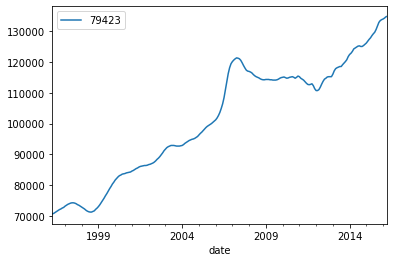

In [54]:
train =  df_79423[:-24]
test = df_79423[-241:]
train.plot()

Trend Analysis

<AxesSubplot:xlabel='date'>

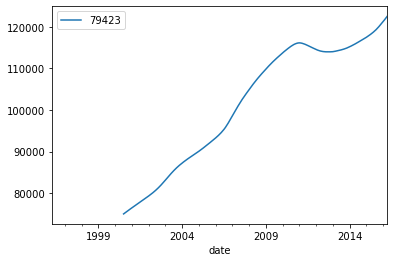

In [55]:
# Plot the rolling mean with a window of a year

roll_mean = train.rolling(window=52).mean()
roll_mean.plot()

<AxesSubplot:xlabel='date'>

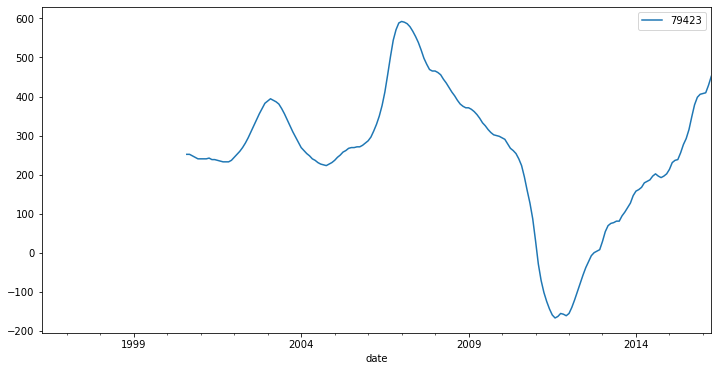

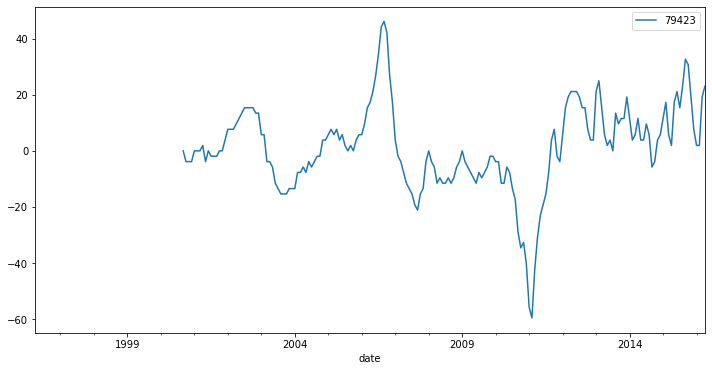

In [56]:
# Apply a 1st order difference to the time series and plot the rolling mean

rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6))


In [63]:
def stationarity_check(df):     
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

In [82]:
print(stationarity_check(df_79423))
print(stationarity_check(rm_diff_2.dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                  -0.347471
p-value                          0.918507
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                  -2.413832
p-value                          0.137871
#Lags Used                      12.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64
None


In [106]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train, order=(1, 0, 0))
sm = arima.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  79423   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1873.844
Date:                Wed, 06 Oct 2021   AIC                           3753.688
Time:                        14:12:22   BIC                           3764.142
Sample:                    04-01-1996   HQIC                          3757.900
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.015e+05   3.11e+04      3.259      0.001    4.04e+04    1.62e+05
ar.L1          0.9998      0.002    404.348      0.000       0.995       1.005
sigma2      3.212e+05    1.7e+04     18.887      0.0

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [94]:
train_hat = sm.predict()
train_hat

1996-04-01    101461.004266
1996-05-01     70705.157783
1996-06-01     70905.124248
1996-07-01     71205.073946
1996-08-01     71505.023644
                  ...      
2015-12-01    133394.644700
2016-01-01    133694.594398
2016-02-01    133894.560864
2016-03-01    134194.510562
2016-04-01    134594.443493
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [95]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, train_hat, squared=False)
rmse


2060.6030994609373

In [107]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(train, order=[1,0,0]).fit()
sarimax.summary()

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  79423   No. Observations:                  241
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1875.096
Date:                Wed, 06 Oct 2021   AIC                           3754.193
Time:                        14:14:19   BIC                           3761.162
Sample:                    04-01-1996   HQIC                          3757.000
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000    8.9e-05   1.12e+04      0.000       1.000       1.000
sigma2      3.207e+05    9.4e-14   3.41e+18      0.000    3.21e+05    3.21e+05
===================================================================================
Ljung-Box (L1) (Q):                 202.16   Jarque-Bera (JB):               392.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             1.41
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.04e+34. Standard errors may be unstable.
"""

In [108]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, train_hat, squared=False)
rmse


2060.6030994609373

In [110]:
def print_ts_metrics(endog=train, test=test, order=[0,0,0], seasonal_order=[0,0,0,0]):
    
    '''
    Print out RMSE for a given set of orders (seasonal and non-seasonal)
    Return the model fit on the training set.
    '''
    
    sm = SARIMAX(endog, order=order, seasonal_order=seasonal_order).fit()
    rmse_endog = mean_squared_error(endog, 
                             sm.predict(endog.index[0], endog.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    rmse_test = mean_squared_error(test, 
                             sm.predict(test.index[0], test.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    print(rmse_endog)
    
    print(rmse_test)
    return sm

In [111]:
def plot_predictions(test=test, sarimax=sarimax):
    sarimax.predict(test.index[0], test.index[-1], typ='levels').plot()
    test.plot()

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


5154.786399537967
2633.0472247230427


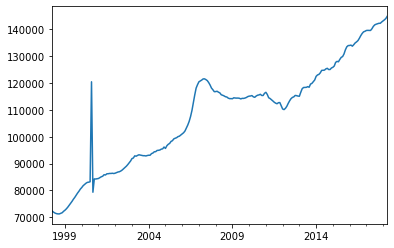

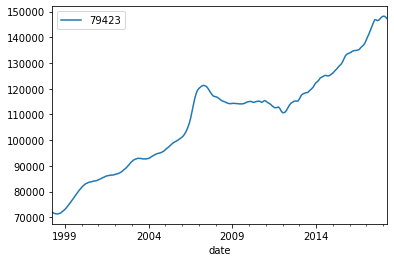

In [112]:
# set print_ts_metrics equal to model, then feed that model to plot_predictions
model = print_ts_metrics(endog=train, test=test, order=[1,1,0], seasonal_order=[1,1,0,52])
plot_predictions(test, model)

# Zipcode 75104

In [113]:
df_75104 = pd.DataFrame(df_p[75104][df_p[75104].notnull()]).astype(int) 
df_75104['value'] = df_75104[75104] 
df_75104.drop(df_75104.columns[np.r_[1]], axis=1, inplace=True)
df_75104 

,75104
date,
1996-04-01,98300
1996-05-01,98500
1996-06-01,98700
1996-07-01,99000
1996-08-01,99200
...,...
2017-12-01,184400
2018-01-01,187000
2018-02-01,189100


<AxesSubplot:xlabel='date'>

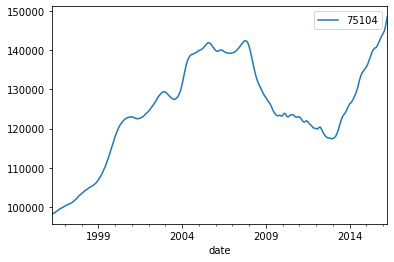

In [114]:
train =  df_75104[:-24]
test = df_75104[-241:]
train.plot()

<AxesSubplot:xlabel='date'>

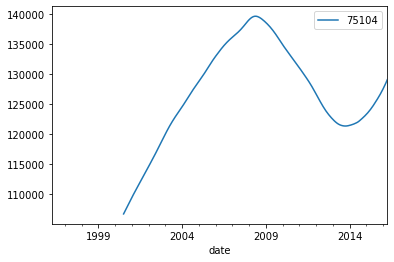

In [115]:
# Plot the rolling mean with a window of a year

roll_mean = train.rolling(window=52).mean()
roll_mean.plot()

<AxesSubplot:xlabel='date'>

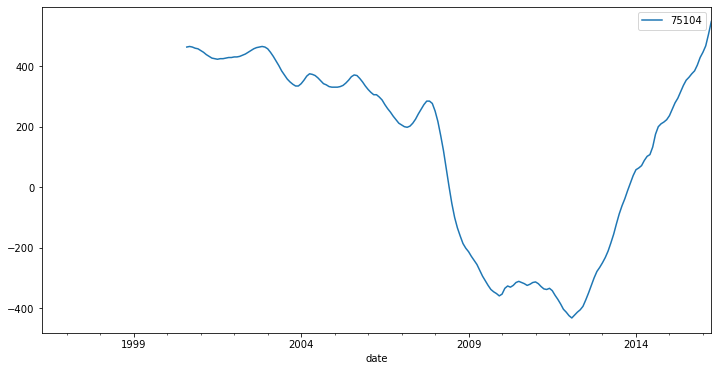

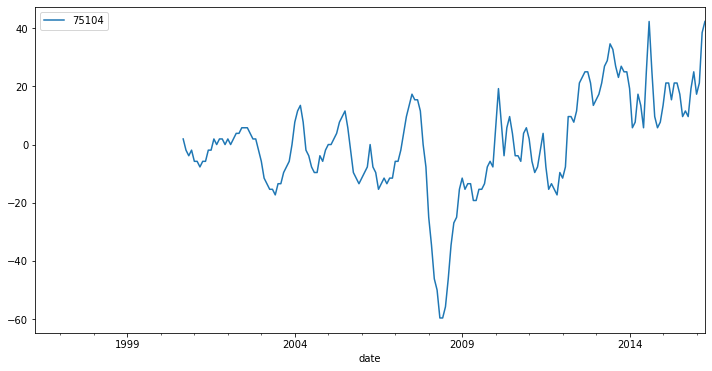

In [116]:
# Apply a 1st order difference to the time series and plot the rolling mean

rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6))


In [117]:
def stationarity_check(df):     
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

In [118]:
print(stationarity_check(df_79423))
print(stationarity_check(rm_diff_2.dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                  -0.347471
p-value                          0.918507
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                  -1.724024
p-value                          0.418779
#Lags Used                      15.000000
Number of Observations Used    172.000000
Critical Value (1%)             -3.468952
Critical Value (5%)             -2.878495
Critical Value (10%)            -2.575809
dtype: float64
None


In [119]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train, order=(1, 0, 0))
sm = arima.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  79423   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1873.844
Date:                Wed, 06 Oct 2021   AIC                           3753.688
Time:                        14:45:45   BIC                           3764.142
Sample:                    04-01-1996   HQIC                          3757.900
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.015e+05   3.11e+04      3.259      0.001    4.04e+04    1.62e+05
ar.L1          0.9998      0.002    404.348      0.000       0.995       1.005
sigma2      3.212e+05    1.7e+04     18.887      0.0

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [120]:
train_hat = sm.predict()
train_hat

1996-04-01    125149.784748
1996-05-01     98309.110360
1996-06-01     98509.042498
1996-07-01     98708.974637
1996-08-01     99008.872844
                  ...      
2015-12-01    142794.011132
2016-01-01    143593.739685
2016-02-01    144193.536100
2016-03-01    144893.298584
2016-04-01    146492.755691
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [121]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, train_hat, squared=False)
rmse

1837.6825887434738

In [122]:
def print_ts_metrics(endog=train, test=test, order=[0,0,0], seasonal_order=[0,0,0,0]):
    
    '''
    Print out RMSE for a given set of orders (seasonal and non-seasonal)
    
    Return the model fit on the training set.
    '''
    
    sm = SARIMAX(endog, order=order, seasonal_order=seasonal_order).fit()
    rmse_endog = mean_squared_error(endog, 
                             sm.predict(endog.index[0], endog.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    rmse_test = mean_squared_error(test, 
                             sm.predict(test.index[0], test.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    print(rmse_endog)
    
    print(rmse_test)
    return sm

In [123]:
def plot_predictions(test=test, sarimax=sarimax):
    sarimax.predict(test.index[0], test.index[-1], typ='levels').plot()
    test.plot()

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


7445.63730349451
8944.638003392693


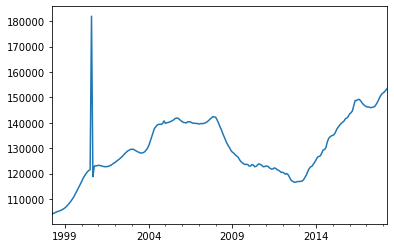

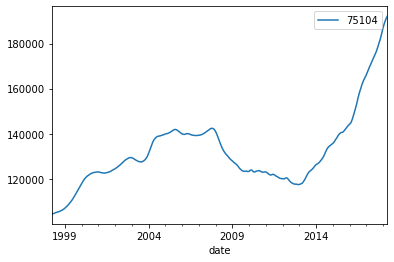

In [124]:
# set print_ts_metrics equal to model, then feed that model to plot_predictions
model = print_ts_metrics(endog=train, test=test, order=[1,1,0], seasonal_order=[1,1,0,52])
plot_predictions(test, model)